# <img src="./assets/anpl_solo_logo.png" style="height:50px;display:inline"> DDS 0970252 - Autonomous Planning Under Uncertainty
---

**Moshe Rafaeli** - [moshiktech@gmail.com](mailto:moshiktech@gmail.com) \
**Tamir Shazman** - [tmyr@campus.technion.ac.il](mailto:tmyr@campus.technion.ac.il)

Course website: https://anpl-technion.github.io/Teaching/#POMDP \
Course forum and announcements: https://piazza.com/technion.ac.il/fall2025/0970252


## <img width="48" height="48" src="https://img.icons8.com/external-becris-lineal-color-becris/64/external-probability-data-science-becris-lineal-color-becris.png" alt="external-probability-data-science-becris-lineal-color-becris"/> Tutorial 1: Foundations of Probability, Bayesian Inference, Environment Representation and Julia

---

**Notebook kernel:** `Julia` (recommended version ≥ 1.11)

**Packages used (install if needed):**

In [1]:
using Pkg
Pkg.add(["Distributions", "LinearAlgebra", "Random", "Statistics", "Plots", "StatsBase", "Combinatorics", "POMDPTools"])


   Resolving package versions...
  No Changes to `C:\Users\moshi\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\moshi\.julia\environments\v1.11\Manifest.toml`


In [2]:
using LinearAlgebra, Random, Distributions, Statistics, Plots, StatsBase, Combinatorics, POMDPTools

### Basic probability - discrete random variables

---

In [3]:
Random.seed!(0970252) # we will use this seed for all random processes in the tutorials

# PMF for biased coin (Heads with prob 0.7)
p_head = 0.7
support = ["H","T"]
pmf = Dict("H"=>p_head, "T"=>1-p_head)

# sample many times and estimate empirical PMF
n = 10000
samples = rand(Binomial(1,p_head), n)   # 1 ~ H, 0 ~ T
emp_counts = countmap(samples)
emp_pmf = Dict("H" => emp_counts[1]/n, "T" => emp_counts[0]/n)

# show the true PMF vs the empirical PMF
println("True PMF:\t", pmf)
println("Empirical PMF:\t", emp_pmf)

True PMF:	Dict("T" => 0.30000000000000004, "H" => 0.7)
Empirical PMF:	Dict("T" => 0.2966, "H" => 0.7034)


### Continuous random variables - PDF, sampling, histogram

---

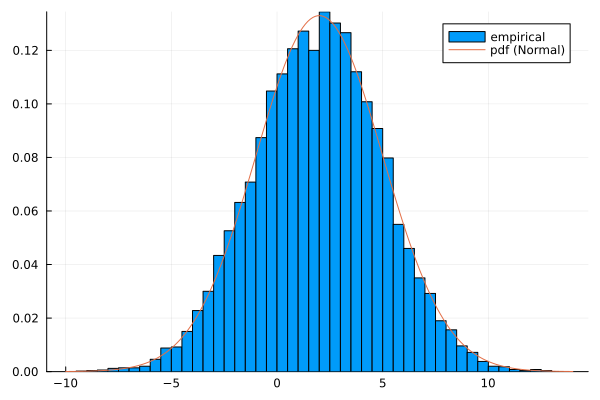

In [4]:
Random.seed!(0970252)

# PDF for Normal distribution
μ, σ = 2.0, 3.0
xs = range(μ-4σ, μ+4σ, length=200)
x_pdf = exp.(-(xs .- μ).^2 ./ (2*(σ^2))) ./ sqrt(2π*(σ^2))

# samples from Normal distribution
rv = Normal(μ, σ)
x_empirical = rand(rv, 10000)

# plot histogram of samples and overlay true PDF
histogram(x_empirical, bins=50, normalize=true, label="empirical")
plot!(xs, x_pdf, label="pdf (Normal)")

### Joint and conditional distributions, marginalization

---

**Example:**
Two Random Variables $X,Y$, with the following joint distribution, and individual distribution:

|$P(X=x,Y=y)$ | $y=0$ | $y=1$ | |
|-|-|-|-|
|$x=0$ | $0.1$ | $0.2$ | $\rightarrow P(X=0)=0.3$ |
|$x=1$ | $0.3$ | $0.4$ | $\rightarrow P(X=1)=0.7$ |
| | $\downarrow \\ P(Y=0)=0.4$ | $\downarrow \\ P(Y=1)=0.6$ | |


In [5]:
# Example discrete joint distribution for (X,Y)
pXY = Dict( (0,0)=>0.1,
            (0,1)=>0.2,
            (1,0)=>0.3,
            (1,1)=>0.4)

# marginalize to get p(X)
pX = Dict(0 => pXY[(0,0)]+pXY[(0,1)],
          1 => pXY[(1,0)]+pXY[(1,1)])
# conditional p(X|Y=1)
pY1 = pXY[(0,1)] + pXY[(1,1)]
pX_given_Y1 = Dict(x => pXY[(x,1)]/pY1 for x in (0,1))

println("P(X) =\t\t", pX)
println("P(X|Y=1) =\t", pX_given_Y1)

P(X) =		Dict(0 => 0.30000000000000004, 1 => 0.7)
P(X|Y=1) =	Dict(0 => 0.3333333333333333, 1 => 0.6666666666666666)


### Chain rule and Bayes' rule

---

Example: We have a machine that detects wether a patient is sick.

The patient can either be sick or be healthy, i.e. $X = \{\mathrm{healthy, sick}\}$. The probability of a patient to be sick is 1%. \
The machine returns $\mathrm{Positive}$ if it detects the patient is sick or $\mathrm{Negative}$ otherwise, i.e. $Y = \{\mathrm{Positive, Negative}\}$. \
The machine returns $\mathrm{Positive}$ 95% of the times when the patient is actually sick, and returns $\mathrm{Positive}$ 3% of the times when the patient is actually healthy.

What is the probability a patient is sick, given the machine returned $\mathrm{Positive}$?

Bayes Rule:
$$
\mathbb{P}(\mathrm{sick} \mid \mathrm{Positive}) = \frac{\mathbb{P}(\mathrm{Positive} \mid \mathrm{sick}) \cdot \mathbb{P}(\mathrm{sick})}{\mathbb{P}(\mathrm{Positive})}
$$

Marginalization & Chain Rule:
$$
\mathbb{P}(\mathrm{Positive}) = \mathbb{P}(\mathrm{Positive, sick}) + \mathbb{P}(\mathrm{Positive, healthy}) = \mathbb{P}(\mathrm{Positive \mid sick}) \cdot \mathbb{P}(\mathrm{sick}) + \mathbb{P}(\mathrm{Positive \mid healthy}) \cdot (1 - \mathbb{P}(\mathrm{sick})) 
$$

In [6]:
# probabilities for the medical test example
p_sick = 0.01
p_pos_given_sick = 0.95
p_pos_given_healthy = 0.03

# Bayes and Chain rules
p_pos = p_pos_given_sick*p_sick + p_pos_given_healthy*(1-p_sick)
p_sick_given_pos = (p_pos_given_sick * p_sick)/p_pos

println("P ( Sick | Positive ) = ", p_sick_given_pos)

P ( Sick | Positive ) = 0.2423469387755102


### Expectation and covariance

---

In [7]:
Random.seed!(0970252)

μ, σ = 1.0, 2.0
# generate samples from Normal distribution
x = rand(Normal(μ, σ), 10000)
E_x = mean(x)
Var_x = var(x)

# generate samples from 2D Gaussian and estimate covariance matrix
μ1, σ1 = 0.0, 1.0
μ2, σ2 = 2.0, 1.5
X = [rand(Normal(μ1, σ1),5000) rand(Normal(μ2, σ2),5000)]
cov_est = cov(X)

println("1D Gaussian: mean = $(μ), variance = $(σ^2)")
println("Empirical mean = $(E_x), Empirical variance = $(Var_x)")
println()
println("2D Gaussian: true means = [$(μ1), $(μ2)], true variances = [$(σ1^2), $(σ2^2)]")
println("Empirical Covariance matrix:\n", repr("text/plain",cov_est))

1D Gaussian: mean = 1.0, variance = 4.0
Empirical mean = 0.9663147301780304, Empirical variance = 3.977300658987374

2D Gaussian: true means = [0.0, 2.0], true variances = [1.0, 2.25]
Empirical Covariance matrix:
2×2 Matrix{Float64}:
  1.01026    -0.0392326
 -0.0392326   2.29468


### Gaussian distributions and information form

---

In [8]:
# Covariance form
μ = [1.0, -0.5]
Σ = [0.5 0.1; 0.1 0.2]

println("Covariance Form:")
println("μ = ", μ)
println("Σ = \n", repr("text/plain",Σ))

Covariance Form:
μ = [1.0, -0.5]
Σ = 
2×2 Matrix{Float64}:
 0.5  0.1
 0.1  0.2


In [9]:
# Information form
Λ = inv(Σ)
η = Λ * μ

println("Information Form:")
println("η = ", η)
println("Λ = \n", repr("text/plain",Λ))

Information Form:
η = [2.7777777777777777, -3.888888888888889]
Λ = 
2×2 Matrix{Float64}:
  2.22222  -1.11111
 -1.11111   5.55556


In [10]:
# back to covariance form
Σ2 = inv(Λ)
μ2 = Σ2 * η

println("Back to Covariance Form:")
println("Recovered μ = ", μ2)
println("Original μ = ", μ)

Back to Covariance Form:
Recovered μ = [0.9999999999999998, -0.5]
Original μ = [1.0, -0.5]


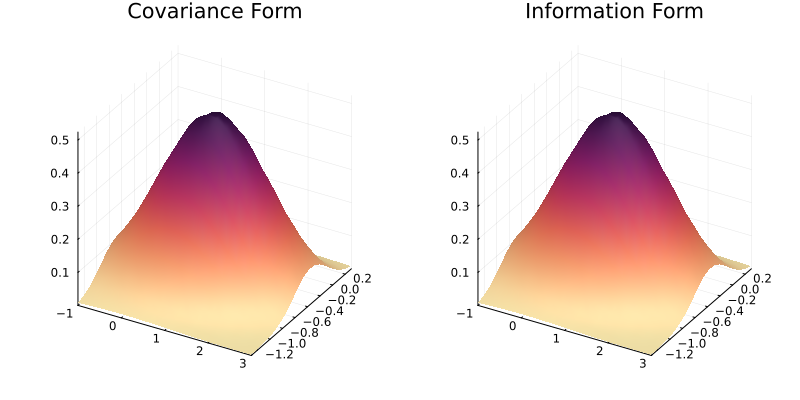

In [11]:
# PDF for distribution for Covariance form
xs = range(μ[1]-4*Σ[1,1], μ[1]+4*Σ[1,1], length=20)
ys = range(μ[2]-4*Σ[2,2], μ[2]+4*Σ[2,2], length=20)
x_cov_pdf = [exp(-0.5*([x,y]-μ)'*inv(Σ)*([x,y]-μ)) / (2π*sqrt(det(Σ))) for x in xs, y in ys]
x_inf_pdf = [exp(-0.5*([x,y]'*Λ*[x,y] - 2*η'*[x,y] + μ'*Λ*μ)) / (2π*sqrt(det(Σ))) for x in xs, y in ys]

# plot the two PDFs side by side
p1 = plot(xs, ys, x_cov_pdf, linetype=:surface, color=:matter, title="Covariance Form", legend=false)
p2 = plot(xs, ys, x_inf_pdf, linetype=:surface, color=:matter, title="Information Form", legend=false)
plot(p1, p2, layout=(1, 2), size=(800, 400))

### Bayesian Inference - The Tiger Problem

---

The Tiger Problem is a classic example in decision-making under uncertainty.
We present now a _simplified version_ of the problem (without rewards or actions).

![Tiger POMDP](./assets/tiger-pomdp.png)

An agent faces two closed doors: behind one is a tiger, behind the other is treasure.
The agent listens to the doors to gather information about the tiger's location.

- **States ($X$):**
    - $X = \{\text{tiger-left},\ \text{tiger-right}\}$

- **Observations ($Z$):**  
    - $Z = \{\text{hear-left},\ \text{hear-right}\}$  

The agent listens to the doors and receives an observation $z \in Z$ indicating which door the tiger might be behind, but the observation is noisy.

In [12]:
# The Tiger Problem Example
xs = [:TigerLeft, :TigerRight]  # state space
zs = [:HearLeft, :HearRight]    # observation space

# NOTE: you can change these parameters to see how the inference changes.
pX = Dict(x=>1/length(xs) for x in xs)   # prior P(X) - uniform
pZ_given_X = Dict(  :TigerLeft => Dict(:HearLeft=>0.8, :HearRight=>0.2),
                    :TigerRight => Dict(:HearLeft=>0.3, :HearRight=>0.7) ) # likelihood P(Z|X) - observation model

"""
Perform Bayesian Inference to compute the posterior distribution _P(X|z)_ given:
- `xs`: support of _X_ (discrete and finite)
- `pX`: prior distribution _P(X)_ over the support of _X_ `xs` as a Dictionary, e.g., `pX[x]` = _P(X=x)_
- `pZ_given_X`: likelihood _P(Z|X)_ as a Dictionary of Dictionaries, e.g., `pZ_given_X[x][z]` = _P(Z=z|X=x)_
- `z`: observed value of _Z_
"""
function bayesian_inference(xs, pX, pZ_given_X, z)
    # compute p(z)
    pz = sum(pZ_given_X[x][z]*pX[x] for x in xs)
    # compute p(X|z)
    pX_given_z = Dict(x => (pZ_given_X[x][z]*pX[x])/pz for x in xs)
    return pX_given_z
end
;

In [13]:
Random.seed!(0970252)

# set the true state of the tiger and the observations, these are unknown to the agent
true_state = :TigerRight
false_state = :TigerLeft
true_observations = :HearRight
false_observations = :HearLeft

println("Initial Probabilities: ", pX)
println()
# Start listening until we are sure where the tiger is
while all(pX[x] < 0.9 for x in xs)
    # listen and get observation
    z = rand(Binomial(1, pZ_given_X[true_state][true_observations])) == 1 ? true_observations : false_observations
    println("Observation: ", z)
    # bayesian inference
    pX = bayesian_inference(xs, pX, pZ_given_X, z)
    println("Probabilities: ", pX)
    println()
end

println("True Tiger location:\t", true_state)
println("Agent thinks that:\t", argmax(pX))

Initial Probabilities: Dict(:TigerLeft => 0.5, :TigerRight => 0.5)

Observation: HearLeft
Probabilities: Dict(:TigerLeft => 0.7272727272727273, :TigerRight => 0.2727272727272727)

Observation: HearRight
Probabilities: Dict(:TigerLeft => 0.4324324324324325, :TigerRight => 0.5675675675675675)

Observation: HearRight
Probabilities: Dict(:TigerLeft => 0.17877094972067045, :TigerRight => 0.8212290502793296)

Observation: HearRight
Probabilities: Dict(:TigerLeft => 0.05855443732845382, :TigerRight => 0.9414455626715462)

True Tiger location:	TigerRight
Agent thinks that:	TigerRight


### Transition model and observation model - Bayesian update in 1D

---

**Example:**

Variable $x \in \mathbb{N}$ represents the position of a robot on a 1D line.
The variable _changes through time_ as the robots moves, i.e. $\{ x_0, x_1, x_2, ... \}$. \
The robot does not know it's true position, but it maintains a distribution over it's possible position at each time step $t$. \
$X_t$ is the random variable representing the position of the robot at time $t$.

The robot has a _prior distribution_ about it's initial position, $\mathbb{P}(X_0)$. \
Each time step $t$ the robot moves according to an _action_ $a_t$, which changes it's position at the next time step.
This is the _transition model_ of $X_t$ over time, $\mathbb{P}(X_{t+1} \mid X_{t}, a_{t})$. \
After the action is performed and position changed to $x_{t+1}$, the robot gets an _observation_ from it's new position, $z_{t+1}$.
This is the _observation model_ for each time step $t$, $\mathbb{P}(Z_t \mid X_t)$. \
The robot uses the observation to update the _posterior distribution_ over it's position, $\mathbb{P}(X_t \mid a_{0:t-1}, z_{1:t})$. \
The robot's estimation of it's position at each time $t$ is the Maximum a posteriori (MAP) estimator:
$$ x^*_{t} = \argmax_{x_t} \mathbb{P}(x_t \mid a_{0:t-1}, z_{1:t})$$


In this example we consider:
- Prior distribution: $\mathbb{P}(X_0) \sim \mathcal{U}\{-19,20\}$ (discrete uniform distribution).
- Transition model: $X_{t+1} = X_{t} + a_{t} + \omega_{t}$, where $a_t \in \{-1,+1\}$ and
$\omega_{t} = \begin{cases}
    0, & \text{w.p.} ~ 0.8 \\
    +1, & \text{w.p.} ~ 0.1 \\
    -1, & \text{w.p.} ~ 0.1 \\
\end{cases}$,
and independent of $X_t$.
- Observation model: $Z_{t} = X_{t} + \nu_{t}$, where
$\nu_{t} = \begin{cases}
    0, & \text{w.p.} ~ 0.7 \\
    +1, & \text{w.p.} ~ 0.15 \\
    -1, & \text{w.p.} ~ 0.15 \\
\end{cases}$,
and independent of $X_t$.


In [14]:
# Note: you can change these parameters to see how the estimation changes.
x0 = -2 # initial true position

xs = range(-19,20)
pX0 = Dict(x => 1/length(xs) for x in xs) # initial distribution - uniform

w = Dict(0 => 0.8, 1 => 0.1, -1 => 0.1) # motion disturbance
v = Dict(0 => 0.7, 1 => 0.15, -1 => 0.15) # observation noise

get_sample(d) = rand(POMDPTools.SparseCat(keys(d),values(d)))
;

0: Robot at: -2
0: Estimated position: -12

1: Performed action: -1
1: Robot moved to: -3
1: Robot observed: -3
1: Estimated position: -3

2: Performed action: 1
2: Robot moved to: -2
2: Robot observed: -2
2: Estimated position: -2

3: Performed action: 1
3: Robot moved to: -1
3: Robot observed: -1
3: Estimated position: -1

4: Performed action: -1
4: Robot moved to: -2
4: Robot observed: -2
4: Estimated position: -2

5: Performed action: 1
5: Robot moved to: -1
5: Robot observed: -1
5: Estimated position: -1

6: Performed action: 1
6: Robot moved to: 0
6: Robot observed: 0
6: Estimated position: 0

7: Performed action: -1
7: Robot moved to: -1
7: Robot observed: -2
7: Estimated position: -1

8: Performed action: 1
8: Robot moved to: -1
8: Robot observed: -2
8: Estimated position: -1

9: Performed action: 1
9: Robot moved to: 0
9: Robot observed: 1
9: Estimated position: 0

10: Performed action: 1
10: Robot moved to: 1
10: Robot observed: 1
10: Estimated position: 1

11: Performed acti

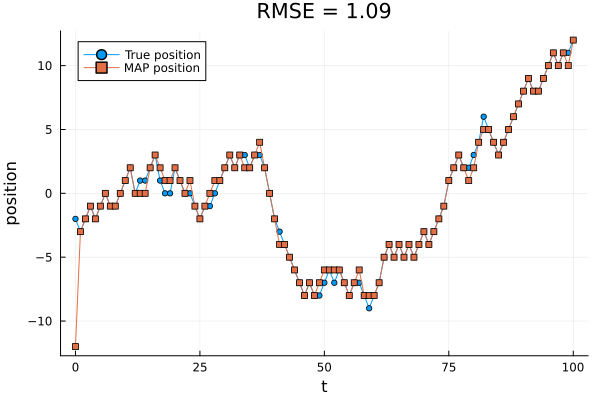

In [15]:
Random.seed!(0970252)

n_steps = 100
controls = [-1, 1] # possible actions of the agent

xt = x0 # true position over time
xt_list = [xt]

pXt = pX0 # distribution over time
est_xt_list = [argmax(pXt)]

println("0: Robot at: ", xt_list[end])
println("0: Estimated position: ", est_xt_list[end])
println()

for t in 1:n_steps
    at = rand(controls) # random control
    # actual movement
    xt += at + get_sample(w)
    zt = xt + get_sample(v)
    push!(xt_list, xt)
    println(t, ": Performed action: ", at)
    println(t, ": Robot moved to: ", xt)
    println(t, ": Robot observed: ", zt)


    # prediction step (perform the action)
    pX_pred = Dict{Int, Float64}()
    for x in keys(pXt)
        for u in keys(w)
            x_pred = x + at + u
            # Note: if x_pred is not in the keys, get!() creates a new key for it with value 0, then we add the new probability
            #       if x_pred is already in the keys, get!() returns its current probability value, then we add the new probability
            pX_pred[x_pred] = get!(pX_pred, x_pred, 0) + pXt[x]*w[u]
        end
    end

    # compute p(zt)
    pzt = 0.0
    for x in keys(pX_pred)
        for u in keys(v)
            if zt == x + u
                pzt += pX_pred[x]*v[u]
            end
        end
    end

    # update step (inference)
    pXt = Dict{Int, Float64}()
    for x in keys(pX_pred)
        for u in keys(v)
            if zt == x + u
                # for a specific value x, there is at most one value u that satisfies zt == x + u
                pXt[x] = (pX_pred[x]*v[u])/pzt
            end
        end
    end
    
    # MAP estimator
    push!(est_xt_list, argmax(pXt))

    println(t, ": Estimated position: ", est_xt_list[end])
    println()
end

# Calculate RMSE of the MAP estimator
rmse = round(sqrt(mean((xt_list .- est_xt_list).^2)), digits=4)

plot(0:n_steps, xt_list, title="RMSE = $(rmse)", label="True position", xlabel="t", ylabel="position", marker=:circle, markersize=3)
plot!(0:n_steps, est_xt_list, label="MAP position", marker=:square, markersize=3)

### Occupancy Grid Map (2D)

---

A **2D occupancy grid map** $m = \{ m_{ij} \}$ is a matrix where each element $m_{ij}$ represents the cell $(i, j)$. \
The probability that the cell $m_{ij}$ is occupied is defined as $p_{ij}$:
$$
p_{ij} = \mathbb{P}(m_{ij} = 1) = \mathbb{P}(\text{cell } (i,j) \text{ is occupied})
$$
Assuming the cells are _independent_ of each other, the probability of the occupancy map:
$$
\mathbb{P}(m) = \prod_{i,j} \mathbb{P}(m_{ij}) = \prod_{i,j} p_{ij}
$$


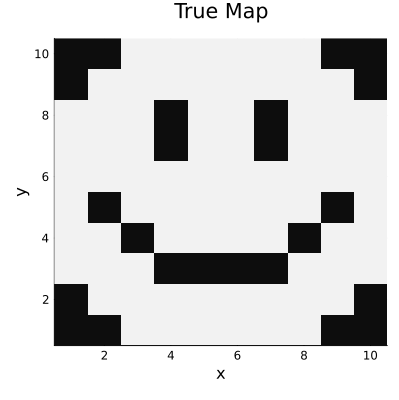

In [16]:
Random.seed!(0970252)

map = [
    1 1 0 0 0 0 0 0 1 1;
    1 0 0 0 1 0 0 0 0 1;
    0 0 0 1 0 0 0 0 0 0;
    0 0 1 0 0 0 1 1 0 0;
    0 0 1 0 0 0 0 0 0 0;
    0 0 1 0 0 0 0 0 0 0;
    0 0 1 0 0 0 1 1 0 0;
    0 0 0 1 0 0 0 0 0 0;
    1 0 0 0 1 0 0 0 0 1;
    1 1 0 0 0 0 0 0 1 1
]
nx, ny = size(map)

heatmap(map', c=cgrad(:grays, rev=true), title="True Map", xlabel='x', ylabel='y', legend=false, size=(400,400))

In [17]:
# Observation model of the robot
pzOcc_given_mOcc = 0.9   # P(Z=occupied | cell=occupied)
pzOcc_given_mFree = 0.3   # P(Z=occupied | cell=free)

"""
Perform Bayesian Inference to update the probability of a cell being occupied, based on the given observation.
- `pmOcc`: probability of the cell being occupied
- `z`: observation of the cell (1 = occupied, 0 = free)
"""
function cell_bayesian_inference(pmOcc, z)
    if z == 1 # observation is occupied
        pz = pzOcc_given_mOcc * pmOcc + pzOcc_given_mFree * (1 - pmOcc)
        pmOcc_next = pzOcc_given_mOcc * pmOcc
        return pmOcc_next / pz
    else # observation is occupied
        pz = (1 - pzOcc_given_mOcc) * pmOcc + (1 - pzOcc_given_mFree) * (1 - pmOcc)
        pmOcc_next = (1 - pzOcc_given_mOcc) * pmOcc
        return pmOcc_next / pz
    end
end

"""
Select a random valid next position from the current position (x, y).
Valid moves are within bounds of the map.
If there are no valid moves, stay in the same position.
- `x`, `x`: current position
- `nx`, `ny`: size of the map
"""
function next_position(x, y, nx, ny)
    # possible moves: up, down, left, right
    moves = [(0,1), (0,-1), (1,0), (-1,0)]
    valid_positions = [(x+dx, y+dy) for (dx,dy) in moves if (0 < x+dx <= nx) && (0 < y+dy <= ny)]
    return isempty(valid_positions) ? (x, y) : rand(valid_positions)
end
;

In [18]:
Random.seed!(0970252)

# log_odds_map = zeros(nx,ny) # log-odds representation of the occupancy grid, initialized to 0 (p=0.5 for all cells)
prob_map = ones(nx,ny)*0.5 # initialized to p_occupied=0.5 for all cells

robot_pos = (1, 1) # starting position of the robot
n_steps = 1000

anim = @animate for iter in 1:n_steps
    # move to a new position
    global robot_pos = next_position(robot_pos[1], robot_pos[2], nx, ny)

    # simulate observation at the new position, assuming for simplicity the observation is noise free
    z = map[robot_pos...]
    println("Step ", iter, ": Robot moved to: ", robot_pos, ", observed: ", z == 1 ? "occupied" : "free")

    # update probability for the observed cell
    prob_map[robot_pos...] = cell_bayesian_inference(prob_map[robot_pos...], z)

    # visualize the current distribution of the map
    heatmap(prob_map', c=cgrad(:grays, rev=true), title="Map distribution @t=$iter", xlabel='x', ylabel='y', size=(400,400))
    scatter!([robot_pos[1]], [robot_pos[2]], markersize=10, markercolor=:red, label="Robot")
end
;

Step 1: Robot moved to: (1, 2), observed: occupied
Step 2: Robot moved to: (1, 3), observed: free
Step 3: Robot moved to: (1, 4), observed: free
Step 4: Robot moved to: (2, 4), observed: free
Step 5: Robot moved to: (3, 4), observed: occupied
Step 6: Robot moved to: (3, 5), observed: free
Step 7: Robot moved to: (2, 5), observed: occupied
Step 8: Robot moved to: (2, 6), observed: free
Step 9: Robot moved to: (2, 5), observed: occupied
Step 10: Robot moved to: (2, 4), observed: free
Step 11: Robot moved to: (2, 3), observed: free
Step 12: Robot moved to: (2, 4), observed: free
Step 13: Robot moved to: (1, 4), observed: free
Step 14: Robot moved to: (1, 5), observed: free
Step 15: Robot moved to: (1, 6), observed: free
Step 16: Robot moved to: (1, 5), observed: free
Step 17: Robot moved to: (1, 4), observed: free
Step 18: Robot moved to: (1, 5), observed: free
Step 19: Robot moved to: (1, 4), observed: free
Step 20: Robot moved to: (1, 5), observed: free
Step 21: Robot moved to: (2, 5), 

[ Info: Saved animation to D:\ANPL\0970252-pomdp\Tutorials\assets\occupancy_grid_mapping.gif


Plots.AnimatedGif("D:\\ANPL\\0970252-pomdp\\Tutorials\\assets\\occupancy_grid_mapping.gif")
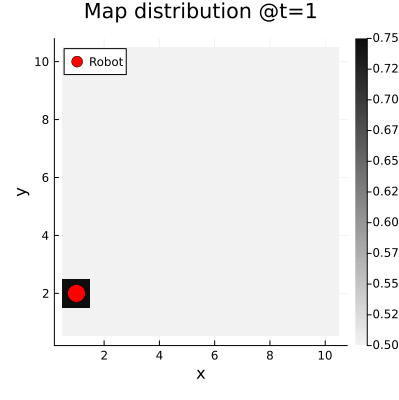

In [19]:
gif(anim, "./assets/occupancy_grid_mapping.gif")

### <img width="48" height="48" src="https://img.icons8.com/color/48/julia.png" alt="julia"/> Using Julia

---

In this course we will use `Julia` for our code examples and implementations, and we encourage you to implement your homework in `Julia` as well.

To run this tutorial locally via [_VSCode_](https://code.visualstudio.com/Download) you need to make sure you have `Julia` installed on your computer.
- **Installing Julia:** Follow this [guide](https://julialang.org/install/) or this [guide](https://julialang.org/downloads/) to install Julia on your computer.

- **VSCode:** To run the tutorial in _VSCode_:
    1. Follow this [guide](https://code.visualstudio.com/docs/languages/julia) to install and use Julia in VSCode.
    2. Then, follow this [guide](https://code.visualstudio.com/docs/datascience/jupyter-notebooks) to run jupyter notebooks directly in VSCode.
    3. After successfully finishing these steps, you can open the tutorial notebook, change the kernel to your installed `Julia` version, and run the tutorial code.

To run this tutorial in [_Google Colab_](https://colab.google.com/) you can upload it to colab (upload the contents of `assets` directory as well), set the runtime type to `Julia` and use a CPU, then run the tutorial.

We encourage you to work in _VSCode_ directly, get familiar with `Julia` and implement your homework in `.jl` files, which allows a better debugging environment. \
For more information about `Julia` please refer to the following sources:
- https://julialang.org/
- https://juliapackages.com/
- https://docs.julialang.org/en/v1/

### <img width="48" height="48" src="https://img.icons8.com/external-bearicons-outline-color-bearicons/64/external-copyright-graphic-design-bearicons-outline-color-bearicons.png" alt="external-copyright-graphic-design-bearicons-outline-color-bearicons"/> Credits

---

- Icons from [Icons8](https://icons8.com/)
- TigerPOMDP image from [People@EECS at UC Berkley](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa13/slides/pomdps.pdf)